## Layers

In [1]:
# test_gcps_pixels = np.array([(8000, 3000), (9000, 3000), (9000, 4000), (11000, 5000)])

In [2]:
import mmcv

mmcv.collect_env()

from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector
from mmrotate.models import build_detector

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

# import grpc
# import messaging_pb2
# import messaging_pb2_grpc

import os
import sys
import random
import cv2
import time
import math

import torch


class ImageProcessingLayer:
    def __init__(
        self,
        output_dim=(500, 500),
        mock=True,
        mock_image_path=None,
        mock_num_samples=10,
        mock_wait_time=1,
        mock_corner_gps_coords=None,
    ):
        self.mock = mock

        if not mock:
            return

        self.mock_wait_time = mock_wait_time

        if mock_image_path is None:
            # mock_image_path = "data/demo.jpg"
            mock_image_path = "data/Blore_Clean.tif"


        self._mock_img_full = np.asarray(Image.open(mock_image_path))[:, :, :3]

        self._output_dim = output_dim
        diag_len = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)
        # self._gcps_pixels = self._generate_random_gcps(
        #     self._mock_img_full, mock_num_samples, padding=(diag_len, diag_len)
        # )
        self._gcps_pixels = np.array([(8000, 3000), (9000, 3000), (9000, 4000), (11000, 5000)])


        self._mock_corner_gps_coords = mock_corner_gps_coords
        self._pixel_to_gps_transform = self._dataset_pixel_to_gps_transform(self._mock_corner_gps_coords)

        self._path_pixels = self._build_path_pixels(self._gcps_pixels)

    def _generate_random_gcps(self, img, num_samples, padding=(0, 0)):
        return np.random.randint(
            padding,
            high=(img.shape[1] - padding[0], img.shape[0] - padding[1]),
            size=(num_samples, 2),
        )

    def _build_path_pixels(self, gcps):
        STEP_SIZE = 400
        
        delta = np.diff(gcps, axis=0)
        directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
        angles = -np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
        delta_angles = np.append(np.diff(angles), 0)

        path = []

        for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
            steps = np.linalg.norm(t2 - t1) / STEP_SIZE
            line = np.linspace(t1, t2, steps.astype("uint32"), dtype="uint32")
            path.extend([np.array([x, y, angle]) for x, y in line])

            if delta_angle == 0:
                continue

            if len(line) == 0:
                continue

            interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
            path.extend(
                [
                    np.array([line[-1][0], line[-1][1], theta])
                    for theta in interpolated_angles
                ]
            )

        return path

    def _next_image(self):
        if self.mock_wait_time > 0:
            time.sleep(self.mock_wait_time)

        sample_diag = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)

        for x, y, theta in self._path_pixels:
            sample = self._crop_around(
                self._mock_img_full, (y, x), (sample_diag, sample_diag)
            )
            rotated_img = self._center_crop(
                rotate(sample, -theta, reshape=False), self._output_dim
            )
          
            theta_radians = theta / 180 * math.pi
            
            center = np.array((x, y))
            
            corner_gps_coords = self._get_corner_gps_coords_of_sample_img(center, theta_radians)
            
            yield rotated_img, corner_gps_coords

    def _crop_around(self, img, center, dim):
        dim = np.array(dim).astype("uint32")
        x = int(center[1] - dim[1] // 2)
        y = int(center[0] - dim[0] // 2)
        return img[y : y + dim[0], x : x + dim[1]]

    def _center_crop(self, img, dim):
        return img[
            img.shape[0] // 2 - dim[0] // 2 : img.shape[0] // 2 + dim[0] // 2,
            img.shape[1] // 2 - dim[1] // 2 : img.shape[1] // 2 + dim[1] // 2,
        ]

    def _rotate_vec2d(self, vec2d, radians):
        """Only rotate a point around the origin (0, 0)."""
        x, y = vec2d
        x_new = x * math.cos(radians) - y * math.sin(radians)
        y_new = x * math.sin(radians) + y * math.cos(radians)

        return np.array([x_new, y_new])

    def _rotate_pixel_about_center(self, xy, center, radians):
        vector_from_center = np.array(xy) - np.array(center)
        return self._rotate_vec2d(vector_from_center, -radians)

    def _sample_pixel_to_dataset_pixel_coords(self, xy, sample_center, radians):
        # Sample pixel coordinate system has (0,0) at the top left of the sample image
        sample_center_in_sample_pixel_coords = np.array((self._output_dim[1], self._output_dim[0])) / 2
        rotated_coords = self._rotate_pixel_about_center(xy, sample_center_in_sample_pixel_coords, radians)
        coords = rotated_coords + sample_center
        return coords

    def _sample_pixel_to_gps_coords(self, xy, sample_center, radians):
        """
            sample_center is the center coordinates (np array) of the sample image in the dataset pixel coordinate system
        """
        dataset_pixel_coords = self._sample_pixel_to_dataset_pixel_coords(xy, sample_center, radians)
        return self._pixel_to_gps_transform(dataset_pixel_coords)
        
    def _get_corner_gps_coords_of_sample_img(self, center, radians):
        """
            center is the center coordinates (np array) of the sample image in the dataset pixel coordinate system
            radians is the angle that the sample image coordinate system is rotated relative to the dataset
                coordinate system (CCW)
            sample_dim is (height, width)
        """

        height, width = self._output_dim
        
        top_left_pixel = np.array((0,0))
        top_right_pixel = np.array((width,0))
        bot_left_pixel = np.array((0,height))
        bot_right_pixel = np.array((width,height))
        
        return [
            self._sample_pixel_to_gps_coords(corner_pixel, center, radians)
            for corner_pixel in [top_left_pixel, top_right_pixel, bot_left_pixel, bot_right_pixel]
        ]

    def _dataset_pixel_to_gps_transform(self, corner_gps_coords):
        height, width = self._mock_img_full.shape[:2]
        top_left_gps, top_right_gps, bot_left_gps, bot_right_gps = corner_gps_coords
        right_vec = (top_right_gps - top_left_gps) / width
        bot_vec = (bot_left_gps - top_left_gps) / height

        transformation = np.array([[right_vec[0], bot_vec[0]], [right_vec[1], bot_vec[1]]])
        
        def transform(pixel):
            return transformation @ pixel + top_left_gps
        
        return transform

    def run(self, img=None):
        if not self.mock:
            assert img is not None, "Image cannot be None"
            return img

        return self._next_image()


class ObjectDetectionLayer:
    def __init__(
        self, config_file=None, checkpoint_file=None, device=torch.device('cpu'), min_confidence=0.3
    ):
        if config_file is None:
            config_file = "examples/oriented_rcnn_r50_fpn_1x_dota_le90.py"
        if checkpoint_file is None:
            checkpoint_file = "examples/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth"

        self.config_file = config_file
        self.checkpoint_file = checkpoint_file
        self.device = device

        self.model = self._load_model()
        self.min_confidence = min_confidence

    def _load_model(self):
        config = mmcv.Config.fromfile(self.config_file)
        config.model.pretrained = None

        model = build_detector(config.model)
        checkpoint = load_checkpoint(
            model, self.checkpoint_file, map_location=self.device
        )

        model.CLASSES = checkpoint["meta"]["CLASSES"]
        model.cfg = config
        model.to(self.device)
        model = model.eval()

        return model

    def _get_bboxes_pixels(self, img):
        padded_img = np.zeros((max(img.shape[0], 1024), max(img.shape[1], 1024), 3))
        padded_img[: img.shape[0], : img.shape[1], :] = img

        vehicle_classes = [
            i for i, c in enumerate(self.model.CLASSES) if "vehicle" in c
        ]

        inference = inference_detector(self.model, padded_img)
        bboxes = [inference[index] for index in vehicle_classes]

        bboxes = np.concatenate(bboxes, axis=0)
        bboxes = bboxes[bboxes[:, 5] > self.min_confidence]

        # the bboxes are in a weird polygonal format, so we convert them to rectangles
        rect_bboxes = (
            np.array(
                [
                    bboxes[:, 1] - bboxes[:, 2] // 2,
                    bboxes[:, 1] + bboxes[:, 2] // 2,
                    bboxes[:, 0] - bboxes[:, 2] // 2,
                    bboxes[:, 0] + bboxes[:, 3],
                    100 * bboxes[:, -1],  # confidence score
                ]
            )
            .astype(int)
            .T
        )

        # follows the format of x0, x1, y0, y1, confidence
        return rect_bboxes

    def _bbox_pixels_to_gps(self, bboxes, gps_corners, img_dim):
        top_left_gps, top_right_gps, bot_left_gps, bot_right_gps = gps_corners
        right_vec = (top_right_gps - top_left_gps) / img_dim[1]
        bot_vec = (bot_left_gps - top_left_gps) / img_dim[0]

        transformation = np.array([[right_vec[0], bot_vec[0]], [right_vec[1], bot_vec[1]]])

        def transform(bbox):
            return transformation @ bbox + top_left_gps
            
        return np.array([transform(bbox) for bbox in bboxes])
    
    def _convert_bbox_to_radial_representation(self, bboxes):
        """
            Given a bbox in the format of x0, x1, y0, y1, confidence.
            Returns a bbox in the format of x, y, r, confidence
        """

        radii = np.sqrt((bboxes[:, 1] - bboxes[:, 0]) ** 2 + (bboxes[:, 3] - bboxes[:, 2]) ** 2)

        return np.array([
            (bboxes[:, 0] + bboxes[:, 1]) / 2,
            (bboxes[:, 2] + bboxes[:, 3]) / 2,
            radii,
            bboxes[:, 4]
        ]).T

    def run(self, img, gps_sample_corners):
        bboxes_pixels = self._get_bboxes_pixels(img)

        if len(bboxes_pixels) == 0:
            return [], []

        bboxes_radial_pixels = self._convert_bbox_to_radial_representation(bboxes_pixels)
        bboxes_radial_gps = self._bbox_pixels_to_gps(bboxes_radial_pixels[:, :2], gps_sample_corners, img.shape)
        return bboxes_radial_gps, bboxes_pixels  # remove the pixels bboxes later


class MavlinkInterfaceLayer:
    def __init__(self, protos_path="pipelined_grpc/protos"):
        self.protos_path = protos_path
        # self.channel = grpc.insecure_channel("localhost:50051")

    def run(self, bboxes):
        if len(bboxes) == 0:
            return

        print(bboxes)

/home/allanlago/anaconda3/envs/rt-flight/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Run the pipeline

In [3]:
DATASET_TOP_LEFT_GPS = np.array((12.86308254761559, 77.5151947517078))
DATASET_TOP_RIGHT_GPS = np.array((12.863010715187013, 77.52267023737696))
DATASET_BOT_LEFT_GPS = np.array((12.859008245256549, 77.5151541499705))
DATASET_BOT_RIGHT_GPS = np.array((12.858936436333265, 77.52262951527761))

DATASET_CORNER_GPS_COORDS = np.array([DATASET_TOP_LEFT_GPS, DATASET_TOP_RIGHT_GPS, DATASET_BOT_LEFT_GPS, DATASET_BOT_RIGHT_GPS])

/home/allanlago/anaconda3/envs/rt-flight/lib/python3.8/site-packages/PIL/Image.py:2855: DecompressionBombWarning: Image size (111695860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/allanlago/Documents/jupyter-notebooks/rt-flight/examples/mmdetection/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: examples/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
showing rotated image


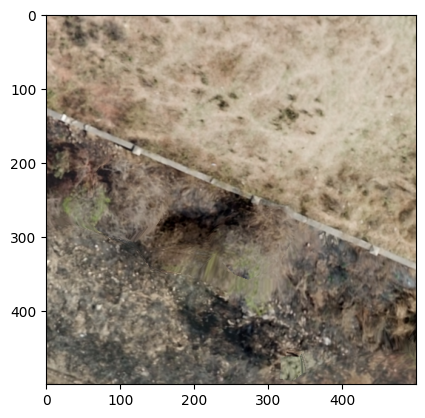

/home/allanlago/Documents/jupyter-notebooks/rt-flight/examples/mmdetection/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


showing rotated image


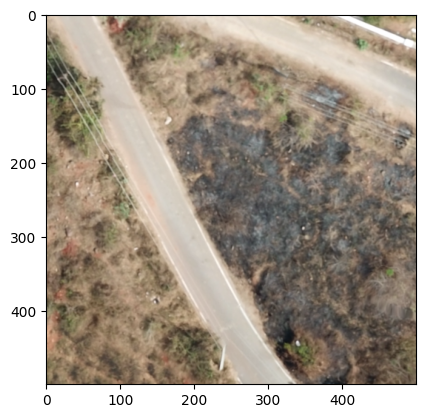

showing rotated image


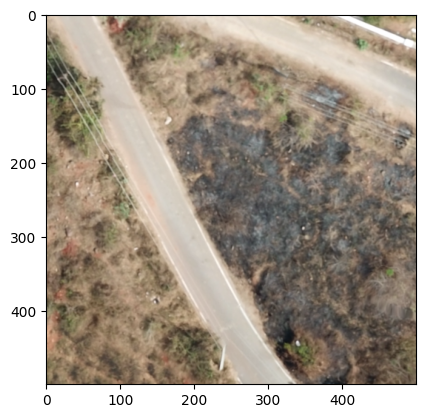

showing rotated image


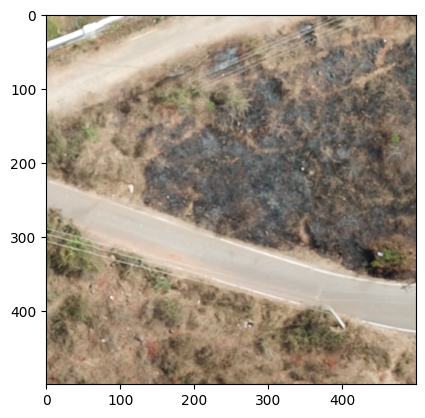

showing rotated image


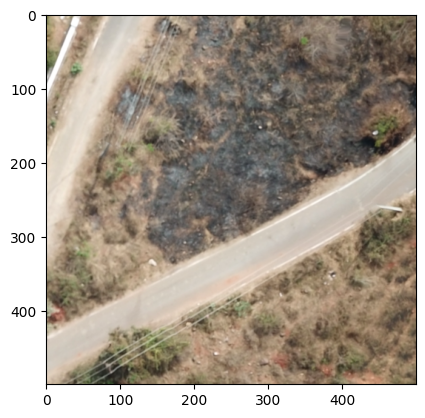

showing rotated image


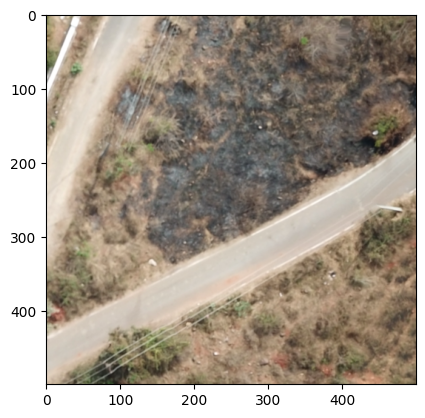

showing rotated image


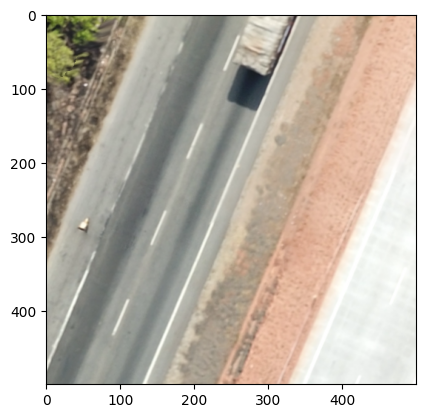

showing rotated image


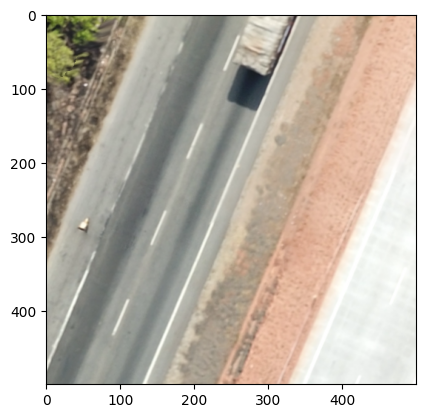

showing rotated image


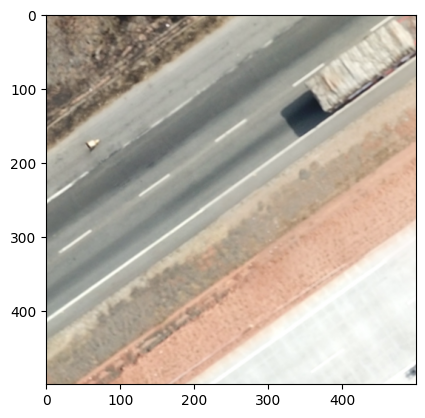

showing rotated image


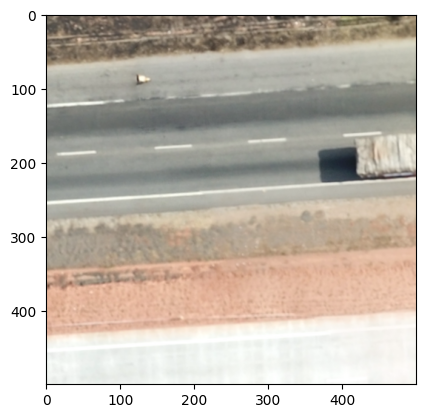

showing rotated image


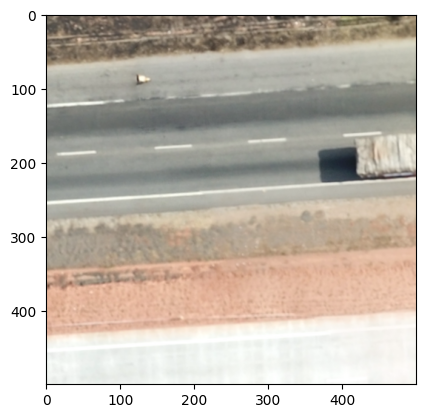

showing rotated image


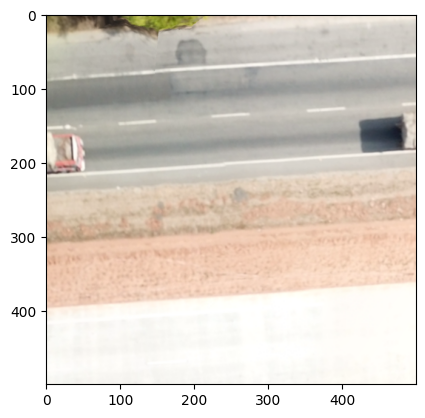

showing rotated image


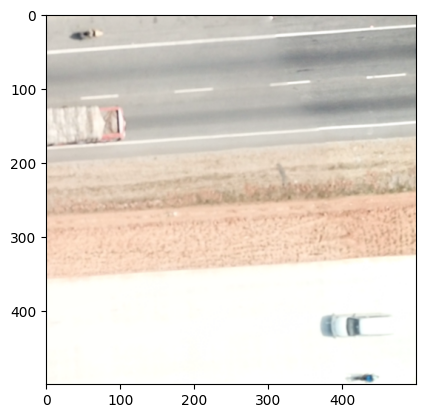

showing rotated image


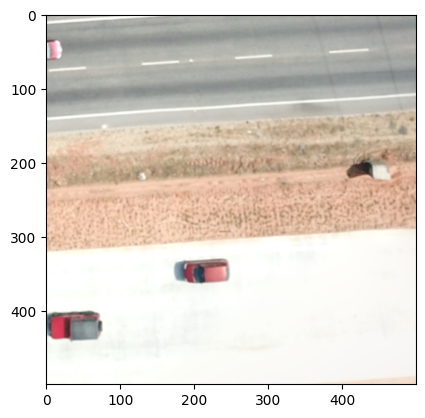

[[348.  212.5]]
(2,) [348.  212.5]


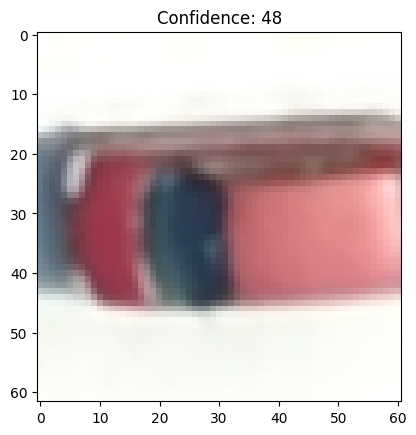

showing rotated image


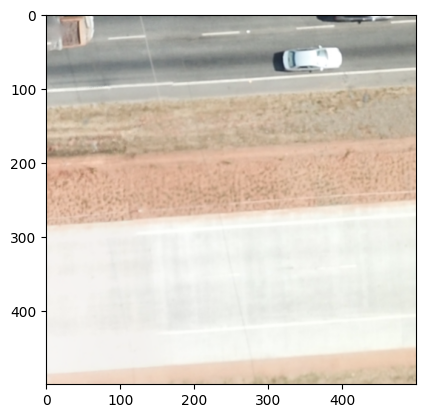

[[ 60. 358.]]
(2,) [ 60. 358.]


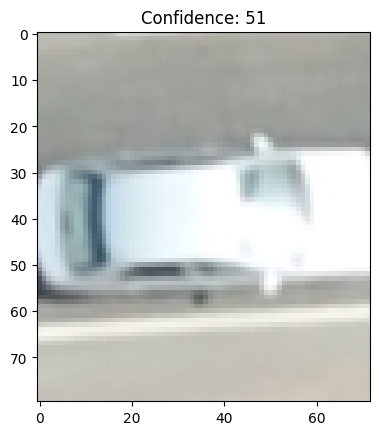

In [4]:
img_layer = ImageProcessingLayer(mock_wait_time=1, mock_corner_gps_coords=DATASET_CORNER_GPS_COORDS)
obj_layer = ObjectDetectionLayer()
mav_layer = MavlinkInterfaceLayer()

detections = []
index = 0
for img, img_corner_gps in img_layer.run():
    print("showing rotated image")
    plt.imshow(img)
    plt.show()
    index = index + 1
    if index == 20:
        break
        
    bboxes_gps, bboxes_pixels = obj_layer.run(img, img_corner_gps)
#     mav_layer.run(bboxes)

    detections.extend(bboxes_gps)
    
    for bbox in bboxes_pixels:
        plt.imshow(img[bbox[0]:bbox[1], bbox[2]:bbox[3]])
        plt.title("Confidence: {}".format(bbox[4]))
        plt.show()

## Bounding box corner coordinate conversion

# Smopy Visualization

In [5]:
import smopy

In [6]:
base_coordinates = np.array(DATASET_CORNER_GPS_COORDS)

min_lat = min(base_coordinates[:,0])
max_lat = max(base_coordinates[:,0])
min_lon = min(base_coordinates[:,1])
max_lon = max(base_coordinates[:,1])

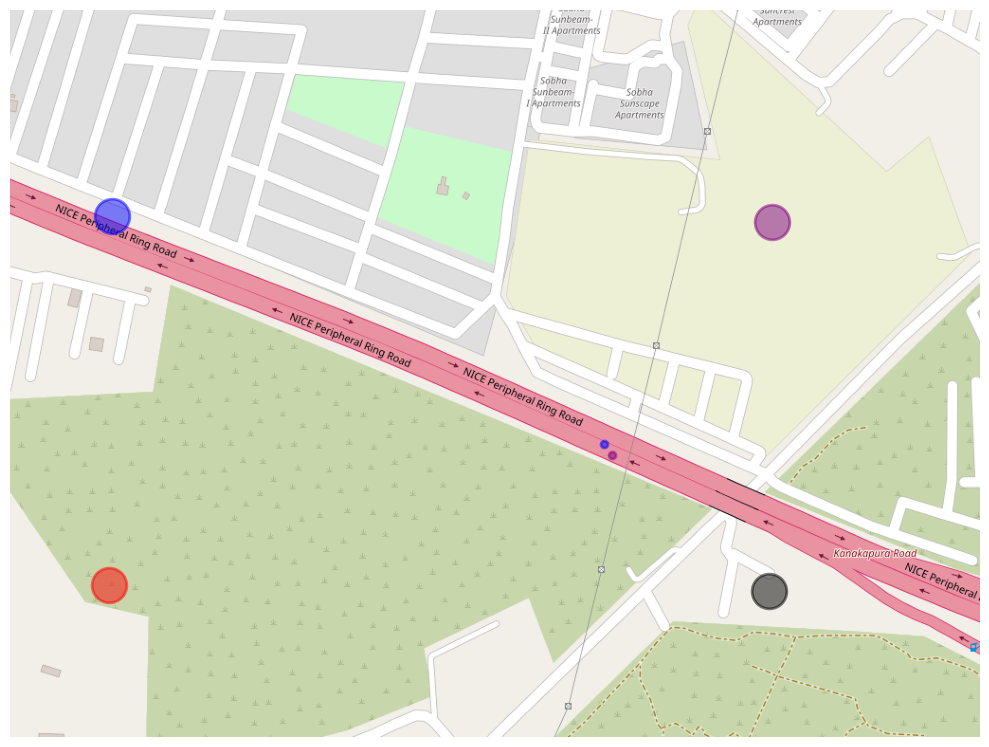

In [12]:
map = smopy.Map((min_lat,min_lon,max_lat,max_lon), z=17)
ax = map.show_mpl(figsize=(10, 10))

# [top left, top right, bottom left, bottom right]
corner_colors = ["blue", "purple", "red", "black"]

# Print dataset corners
for index, dataset_corner_gps in enumerate(DATASET_CORNER_GPS_COORDS):
    dataset_corner_gps = (dataset_corner_gps[0], dataset_corner_gps[1])
    x, y = map.to_pixels(dataset_corner_gps)
    ax.plot(x, y, 'o', ms=25, mew=2, alpha=0.5, color=corner_colors[index]);
        
# Print corners of each bounding box
for index, bb_gps in enumerate(detections):
    x, y = map.to_pixels(list(bb_gps))
    ax.plot(x, y, 'o', ms=5, mew=2, alpha=0.5, color=corner_colors[index]);